# Visual Transformer Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
drive_path = "/content/drive/MyDrive/Apple Disease"
data_path = os.path.join(drive_path, 'img_data.bin')
label_path = os.path.join(drive_path, 'labels.bin')

In [ ]:
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras.optimizers import Adam

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [ ]:
import pickle

with open(data_path, 'rb') as f:
    data = pickle.load(f)
with open(label_path, 'rb') as f:
    labels = pickle.load(f)

In [ ]:
print(data.shape, labels.shape)

(2114, 128, 128, 3) (2114,)


In [ ]:
import numpy as np
np.unique(labels, return_counts=True)

(array([0, 1, 2, 3], dtype=int32), array([618, 621, 275, 600]))

In [ ]:
dat = ['Apple_scab', 'Cedar_apple_rust', 'Frogeye_Spot', 'Healthy']
dat_pos = np.arange(len(dat))
val = [618, 621, 275, 600]

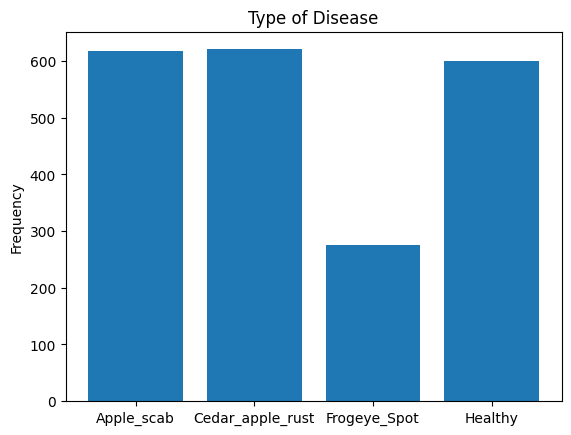

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
bar = ax.bar(dat_pos, val)
ax.set_xticks(dat_pos, labels=dat)
ax.set_ylabel('Frequency')
ax.set_title('Type of Disease')
plt.show()

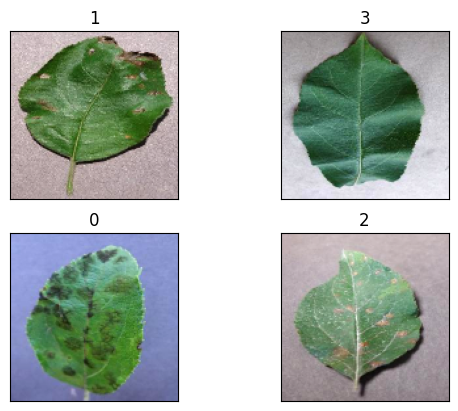

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 2)

for i in range(1, 5):
    ax[i%2, i//3].set(xticks=[], yticks=[])
    ax[i%2, i//3].set_title(labels[i*450])
    ax[i%2, i//3].imshow(data[i*450])
plt.show()

In [ ]:
image_width = 128
image_height = 128
image_channels = 3
num_classes = 4

In [ ]:
augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.Normalization(),
        # tf.keras.layers.Resizing(image_height, image_width),
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(factor=0.02),
        tf.keras.layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="augmentation_layer",
)

In [ ]:
class Patches(tf.keras.layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        input_shape = tf.shape(images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        patches = tf.image.extract_patches(images,
                                           sizes=[1, self.patch_size, self.patch_size, 1],
                                           strides=[1, self.patch_size, self.patch_size, 1],
                                           rates=[1, 1, 1, 1],
                                           padding='VALID'
                                           )
        #print("shape of created patches: ", patches.shape)
        patches = tf.reshape(
            patches,
            (
                batch_size,
                num_patches_h * num_patches_w,
                self.patch_size * self.patch_size * channels,
            ),
        )
        #print("after reshaping:", patches.shape)
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config

In [ ]:
import numpy as np

class PatchEncoder(tf.keras.layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = tf.keras.layers.Dense(units=projection_dim)
        self.position_embedding = tf.keras.layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.expand_dims(
            np.arange(start=0, stop=self.num_patches, step=1), axis=0
        )
        projected_patches = self.projection(patch)
        encoded = projected_patches + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches})
        return config

In [ ]:
def create_mlp(x, hidden_units, dropout_rate):
    for unit in hidden_units:
        x = tf.keras.layers.Dense(unit, activation=tf.nn.gelu)(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)
    return x

In [ ]:
patch_size = 32
projection_dim = 256  # Dimension of the projected patch embeddings
transformer_units = [
    projection_dim * 2,
    projection_dim
]
mlp_head_units = [
    1024,
    512,
]

In [ ]:
input_shape = (image_height, image_width, 1)
(input_shape[0] // patch_size) * (input_shape[1] // patch_size)

16

In [ ]:
def create_visual_transformer(input_layer):
    num_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)
    # augmented = augmentation(input_layer)

    patches = Patches(patch_size)(input_layer)

    embeddings = PatchEncoder(num_patches, projection_dim)(patches)

    # Transformer layers
    for _ in range(6):
        x1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(embeddings)
        attention_output = tf.keras.layers.MultiHeadAttention(num_heads=8, key_dim=256)(x1, x1)
        x2 = tf.keras.layers.Add()([attention_output, embeddings])
        x3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = create_mlp(x3, transformer_units, 0.1)
        embeddings = tf.keras.layers.Add()([x3, x2])

    representation = tf.keras.layers.LayerNormalization(epsilon=1e-6)(embeddings)
    representation = tf.keras.layers.Flatten()(representation)
    representation = tf.keras.layers.Dropout(0.2)(representation)
    features = create_mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.1)
    # logits = tf.keras.layers.Dense(num_classes, activation='softmax')(features)
    model = tf.keras.models.Model(inputs=(input_layer), outputs=features)
    return model



In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
import tensorflow as tf

shared_input = tf.keras.layers.Input(shape=(image_width, image_height, image_channels))
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(image_width, image_height, image_channels))
vit_model = create_visual_transformer(shared_input)

flatten_layer = tf.keras.layers.GlobalMaxPooling2D()
output_layer = tf.keras.layers.Dense(512, activation='softmax')
vgg_model = tf.keras.models.Sequential([
    shared_input,
    base_model,
    flatten_layer,
    output_layer
])

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
merged_outputs = tf.keras.layers.Concatenate(axis=-1)([vgg_model.output, vit_model.output])

fusion_layer = tf.keras.layers.Dense(1024, activation='relu')(merged_outputs)
dropout_layer = tf.keras.layers.Dropout(0.2)(fusion_layer)
dense_layer = tf.keras.layers.Dense(512, activation='relu')(dropout_layer)
dropout_layer = tf.keras.layers.Dropout(0.2)(dense_layer)

output_layer = tf.keras.layers.Dense(4, activation='softmax')(fusion_layer)

merged_model = tf.keras.models.Model(inputs=shared_input, outputs=output_layer)
merged_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 patches (Patches)           (None, 16, 3072)             0         ['input_1[0][0]']             
                                                                                                  
 patch_encoder (PatchEncode  (None, 16, 256)              790784    ['patches[0][0]']             
 r)                                                                                               
                                                                                                  
 layer_normalization (Layer  (None, 16, 256)              512       ['patch_encoder[0][0]'] 

In [ ]:
# input = tf.keras.layers.Input(shape=(image_width, image_height, image_channels))

# model = create_visual_transformer(input)

# model.summary()

In [ ]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()
ohe.fit(labels.reshape(-1, 1))
label_transformed = ohe.transform(labels.reshape(-1, 1)).toarray()
print(ohe.categories_)
print(label_transformed.shape)

[array([0, 1, 2, 3], dtype=int32)]
(2114, 4)


In [ ]:
from keras.optimizers import RMSprop, SGD
learning_rate, weight_decay = (0.0001, 0.00001)
rms = RMSprop(learning_rate)
sgd = SGD(learning_rate=learning_rate, nesterov=True)

def run_experiment(model, x_train, y_train, x_test, y_test, num_epochs, batch_size):
    # optimizer = optimizers.AdamW(
    #     learning_rate=learning_rate, weight_decay=weight_decay
    # )

    #model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer = rms, metrics=['accuracy'])
    model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])

    checkpoint_filepath = os.path.join(drive_path, 'Assets/checkpoints/cp-{epoch:04d}.ckpt')
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    early_stopping = tf.keras.callbacks.EarlyStopping(
                              patience=5,
                              min_delta=0.001,
                              monitor="val_accuracy",
                              restore_best_weights=True
                              )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback, early_stopping],
    )

    return history

In [ ]:
from sklearn.model_selection import train_test_split

try:
    x_train_pairs, x_test_pairs, y_train_pairs, y_test_pairs = train_test_split(data, label_transformed, test_size=0.2)
except:
    x_train_pairs, x_test_pairs, y_train_pairs, y_test_pairs = train_test_split(data, labels, test_size=0.2)

In [ ]:
d = {'x_train_pairs': x_train_pairs, 'x_test_pairs': x_test_pairs, 'y_train_pairs': y_train_pairs, 'y_test_pairs': y_test_pairs}
for i in d:
    print(i, ' : ', d[i].shape, ' --> ', d[i].dtype)


x_train_pairs  :  (1691, 128, 128, 3)  -->  uint8
x_test_pairs  :  (423, 128, 128, 3)  -->  uint8
y_train_pairs  :  (1691, 4)  -->  float64
y_test_pairs  :  (423, 4)  -->  float64


In [ ]:
X = x_train_pairs
y = y_train_pairs
X_val = x_test_pairs
y_val = y_test_pairs

history = run_experiment(merged_model, X, y, X_val, y_val, num_epochs=10, batch_size=16)

Epoch 1/10
96/96 [==============================] - 40s 154ms/step - loss: 0.1404 - accuracy: 0.9513 - val_loss: 0.3007 - val_accuracy: 0.9294
Epoch 2/10
96/96 [==============================] - 12s 120ms/step - loss: 0.1455 - accuracy: 0.9533 - val_loss: 0.3429 - val_accuracy: 0.8941
Epoch 3/10
96/96 [==============================] - 11s 114ms/step - loss: 0.0737 - accuracy: 0.9724 - val_loss: 0.4288 - val_accuracy: 0.9235
Epoch 4/10
96/96 [==============================] - 11s 115ms/step - loss: 0.1135 - accuracy: 0.9625 - val_loss: 0.4502 - val_accuracy: 0.9118
Epoch 5/10
96/96 [==============================] - 13s 136ms/step - loss: 0.0874 - accuracy: 0.9671 - val_loss: 0.3679 - val_accuracy: 0.9353
Epoch 6/10
96/96 [==============================] - 11s 113ms/step - loss: 0.2366 - accuracy: 0.9290 - val_loss: 0.4647 - val_accuracy: 0.8706
Epoch 7/10
96/96 [==============================] - 11s 110ms/step - loss: 0.0674 - accuracy: 0.9776 - val_loss: 0.3597 - val_accuracy: 0.9118

In [ ]:
merged_model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [ ]:
X_val, y_val = x_test_pairs, y_test_pairs
checkpoint_filepath = os.path.join(drive_path, 'Assets/checkpoints')
merged_model.load_weights(os.path.join(checkpoint_filepath, 'cp-0004.ckpt'))

In [ ]:
_, accuracy = merged_model.evaluate(X_val, y_val)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")

14/14 [==============================] - 113s 8s/step - loss: 0.1594 - accuracy: 0.9527
Test accuracy: 95.27%


In [ ]:
merged_model.save(os.path.join(drive_path, 'Assets/vit_vgg.h5'))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def show_values(pc, fmt="%.2f", **kw):
    pc.update_scalarmappable()
    ax = pc.axes
    for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)


def cm2inch(*tupl):
    inch = 2.54
    if type(tupl[0]) == tuple:
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)


def heatmap(AUC, title, xlabel, ylabel, xticklabels, yticklabels, figure_width=40, figure_height=20, correct_orientation=False, cmap='RdBu'):
    fig, ax = plt.subplots()
    c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap=cmap)
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)
    ax.set_xticklabels(xticklabels, minor=False)
    ax.set_yticklabels(yticklabels, minor=False)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim( (0, AUC.shape[1]) )
    ax = plt.gca()
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    plt.colorbar(c)
    show_values(c)
    if correct_orientation:
        ax.invert_yaxis()
        ax.xaxis.tick_top()
    fig = plt.gcf()
    fig.set_size_inches(cm2inch(figure_width, figure_height))
def plot_classification_report_(classification_report, title='Classification report ', cmap='RdBu'):
    lines = classification_report.split('\n')

    classes = []
    plotMat = []
    support = []
    class_names = []
    for i in range(3):
        lines.remove('')
    for line in lines[1 : (len(lines) - 3)]:
        t = line.strip().split()
        if len(t) < 2: continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        print(v)
        plotMat.append(v)

    print('plotMat: {0}'.format(plotMat))
    print('support: {0}'.format(support))

    xlabel = 'Metrics'
    ylabel = 'Classes'
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup) for idx, sup  in enumerate(support)]
    figure_width = 25
    figure_height = len(class_names) + 7
    correct_orientation = False
    heatmap(np.array(plotMat), title, xlabel, ylabel, xticklabels, yticklabels, figure_width, figure_height, correct_orientation, cmap=cmap)


In [ ]:
y_pred = merged_model.predict(X_val)

14/14 [==============================] - 113s 8s/step


In [ ]:
y_pred_ = np.argmax(y_pred, axis=1)
y_val_ = np.argmax(y_val, axis=1)

In [ ]:
y_val_

array([0, 0, 0, 3, 0, 1, 1, 1, 0, 1, 0, 3, 0, 0, 1, 0, 0, 0, 0, 1, 1, 3,
       1, 1, 0, 1, 3, 0, 1, 1, 2, 0, 1, 0, 0, 2, 0, 3, 0, 1, 3, 0, 2, 3,
       3, 0, 2, 3, 2, 3, 0, 3, 3, 1, 1, 3, 1, 1, 2, 3, 0, 3, 2, 0, 3, 2,
       3, 1, 2, 2, 2, 3, 0, 3, 0, 1, 0, 0, 1, 1, 1, 3, 1, 3, 0, 1, 2, 3,
       1, 1, 1, 1, 1, 3, 3, 3, 1, 3, 1, 0, 3, 2, 1, 3, 3, 1, 1, 0, 2, 1,
       1, 1, 2, 2, 3, 0, 1, 3, 3, 0, 3, 3, 1, 3, 0, 3, 3, 0, 1, 1, 3, 0,
       1, 0, 0, 3, 0, 0, 3, 0, 0, 3, 1, 0, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3,
       1, 3, 2, 2, 3, 1, 1, 2, 0, 3, 1, 3, 2, 0, 0, 3, 3, 3, 0, 2, 0, 1,
       1, 0, 0, 3, 2, 3, 1, 1, 0, 3, 3, 3, 0, 2, 1, 3, 3, 3, 3, 3, 1, 0,
       0, 3, 1, 0, 1, 1, 1, 1, 3, 1, 2, 0, 1, 1, 0, 0, 1, 0, 2, 1, 3, 1,
       0, 0, 0, 0, 0, 2, 3, 3, 1, 3, 0, 1, 1, 0, 0, 3, 3, 0, 1, 0, 1, 0,
       2, 1, 2, 0, 3, 1, 3, 3, 0, 1, 3, 0, 0, 3, 0, 3, 0, 0, 0, 2, 1, 0,
       0, 3, 0, 3, 1, 1, 0, 3, 3, 1, 1, 0, 1, 0, 0, 1, 3, 3, 2, 2, 2, 1,
       3, 0, 0, 2, 3, 1, 0, 3, 3, 1, 2, 1, 1, 2, 0,

In [ ]:
y_pred_

array([0, 0, 0, 3, 0, 1, 1, 1, 0, 1, 0, 3, 0, 0, 1, 0, 0, 0, 0, 1, 1, 3,
       1, 1, 0, 1, 3, 0, 1, 1, 2, 0, 1, 0, 0, 2, 0, 3, 0, 1, 3, 0, 2, 3,
       0, 0, 2, 3, 2, 3, 0, 3, 3, 1, 2, 3, 1, 1, 2, 3, 0, 3, 2, 3, 3, 2,
       3, 1, 2, 2, 2, 3, 0, 3, 0, 1, 0, 0, 1, 1, 1, 3, 1, 3, 0, 1, 2, 3,
       1, 1, 1, 1, 1, 3, 3, 3, 1, 3, 1, 0, 3, 2, 1, 3, 3, 1, 1, 0, 2, 1,
       1, 1, 2, 2, 3, 0, 1, 3, 3, 0, 3, 0, 1, 3, 0, 3, 3, 0, 1, 1, 3, 0,
       1, 0, 0, 3, 0, 0, 3, 0, 0, 3, 1, 0, 1, 1, 1, 1, 1, 3, 3, 3, 2, 3,
       1, 3, 2, 2, 3, 1, 1, 2, 0, 3, 1, 3, 2, 0, 0, 3, 3, 3, 0, 2, 0, 1,
       1, 0, 0, 3, 2, 0, 1, 1, 0, 3, 3, 3, 0, 2, 1, 1, 3, 3, 3, 3, 1, 0,
       0, 3, 1, 0, 1, 1, 1, 2, 3, 1, 2, 0, 1, 1, 0, 0, 1, 0, 2, 1, 3, 1,
       0, 0, 0, 0, 0, 2, 3, 3, 1, 3, 0, 1, 1, 0, 0, 3, 3, 0, 1, 0, 1, 1,
       2, 1, 2, 0, 3, 1, 3, 3, 0, 1, 3, 0, 0, 3, 0, 3, 0, 0, 0, 2, 1, 0,
       0, 3, 0, 3, 1, 1, 2, 1, 3, 1, 1, 0, 1, 0, 0, 1, 3, 3, 2, 2, 2, 1,
       3, 0, 0, 2, 3, 1, 0, 3, 3, 1, 2, 1, 1, 2, 0,

In [ ]:
from sklearn.metrics import classification_report
report = classification_report(y_val_, y_pred_, target_names=['0','1','2','3'])

In [ ]:
_, accuracy = merged_model.evaluate(X_val, y_val)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")

14/14 [==============================] - 127s 7s/step - loss: 0.0907 - accuracy: 0.9693
Test accuracy: 96.93%


[0.93, 0.9, 0.92]
[0.94, 0.9, 0.92]
[0.96, 0.94, 0.95]
[0.85, 0.93, 0.89]
plotMat: [[0.93, 0.9, 0.92], [0.94, 0.9, 0.92], [0.96, 0.94, 0.95], [0.85, 0.93, 0.89]]
support: [126, 144, 48, 105]


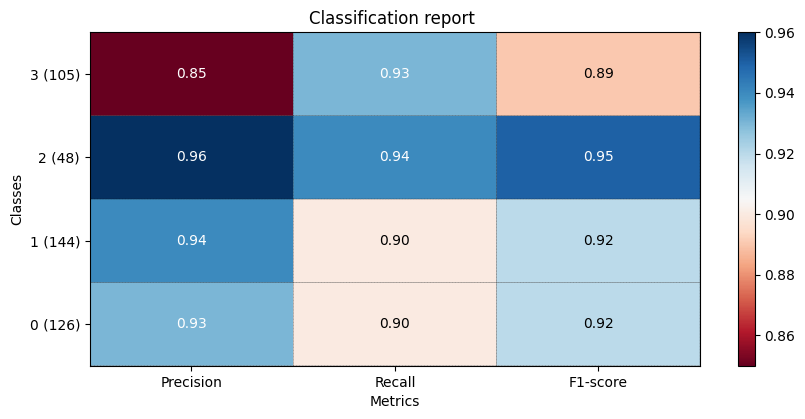

In [ ]:
plot_classification_report_(x)

In [ ]:
X_val, y_val = x_test_pairs, y_test_pairs

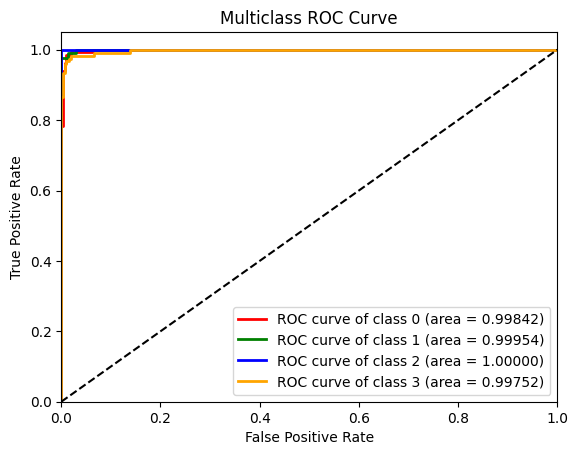

In [ ]:
# prompt: auc roc curve for multiclass classification using classification report
import random
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

y_test = y_val

# Predict probabilities for each class
y_pred_prob = y_pred

# Calculate ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 4

# fpr, tpr, thresholds = roc_curve(y_val, y_probs_positive_class)
# roc_auc = auc(fpr, tpr)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure()
lw = 2
colors = ['red', 'green', 'blue', 'orange']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.5f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend(loc="lower right")
plt.show()


In [ ]:
roc_auc

{0: 0.9984247834077186, 1: 0.9995392953929539, 2: 1.0, 3: 0.9975247524752475}

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_val_, y_pred_)

In [ ]:
cm

array([[0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]])

In [ ]:
predictions = merged_model.predict(X_val)

14/14 [==============================] - 107s 7s/step


ValueError: Classification metrics can't handle a mix of multilabel-indicator and continuous-multioutput targets

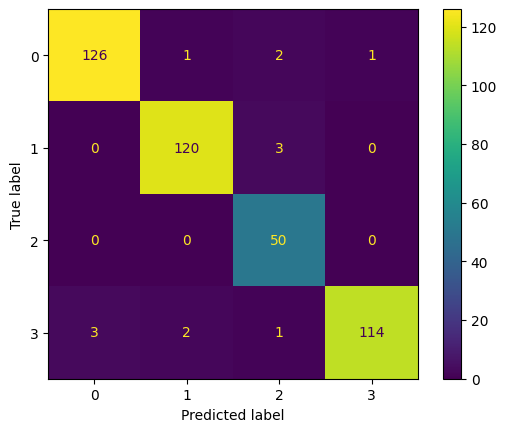

In [ ]:

cm = confusion_matrix(np.argmax(y_test,axis=1), np.argmax(predictions,axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()